<a href="https://colab.research.google.com/github/ivoryRabbit/NIMS_PLIM/blob/gh-pages/4_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN based models

- LSTM과 GRU를 이용해 모델을 학습시켰습니다.
- 2011년도 데이터부터 사용하였습니다.

1. Stacked LSTM
    - 결과: 21.05451
2. Stacked GRU
    - 결과: 20.19185

In [ ]:
import pandas as pd
import numpy as np
import glob, re, gc, os
np.random.seed(777)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, GRU, Flatten, Dropout, Reshape, SpatialDropout1D, TimeDistributed
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('data/train_clean.csv', index_col = 'id')
test = pd.read_csv('data/test.csv', index_col = 'id')
sample_submission = pd.read_csv('data/sample_submission.csv', index_col = 'id')
print(train.shape, test.shape, sample_submission.shape)

(66170, 125) (10000, 113) (10000, 12)


In [ ]:
X = train.loc[:, '2011-06': '2018-05']
y = train.loc[:, '2018-06':]
X_test = test.loc[:, '2011-06':]

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 777)

### 1. Stacked LSTM

In [ ]:
def build_model(input_shape):
    model = Sequential()
    model.add(Reshape((1, input_shape), input_shape = (input_shape, )))
    model.add(LSTM(128, return_sequences = True))
    model.add(LSTM(128, return_sequences = False))

    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(.5))
    model.add(Dense(12, activation = 'linear'))

    adam = Adam(lr=0.0005)
    model.compile(loss = 'mse', optimizer = adam)
    return model

In [ ]:
model = build_model(X_train.shape[1])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 84)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 128)            109056    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_______________________________________

Train on 52936 samples, validate on 13234 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 6s - loss: 3072.1723 - val_loss: 1466.8704
Epoch 2/100
 - 3s - loss: 1735.1803 - val_loss: 1427.0561
Epoch 3/100
 - 3s - loss: 1636.9650 - val_loss: 1384.2495
Epoch 4/100
 - 3s - loss: 1578.7624 - val_loss: 1394.5350
Epoch 5/100
 - 3s - loss: 1534.2300 - val_loss: 1372.3686
Epoch 6/100
 - 3s - loss: 1520.8269 - val_loss: 1417.4758
Epoch 7/100
 - 3s - loss: 1510.1663 - val_loss: 1356.4169
Epoch 8/100
 - 3s - loss: 1512.5480 - val_loss: 1361.8189
Epoch 9/100
 - 3s - loss: 1498.3068 - val_loss: 1376.4470
Epoch 10/100
 - 3s - loss: 1489.6863 - val_loss: 1374.2434
Epoch 11/100
 - 3s - loss: 1478.4859 - val_loss: 1355.7153
Epoch 12/100
 - 3s - loss: 1458.6843 - val_loss: 1345.3213
Epoch 13/100
 - 3s - loss: 1446.5967 - val_loss: 1340.2499
Epoch 14/100
 - 3s - loss: 1450.5021 - val_loss: 1340.8941
Epoch 15/100
 - 3s - loss: 1443.6656 - val_loss: 1324.6053
Epoch 16/100
 - 3s - loss:

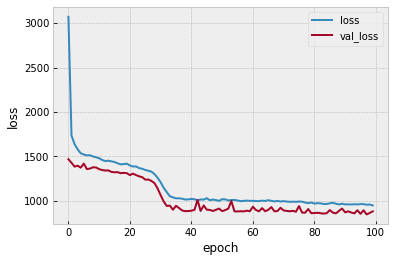

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 20)
model_checkpoint = ModelCheckpoint('models/LSTM_model.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)

hist_model = model.fit(
    X_train, y_train,
    epochs = 100,
    batch_size = 256,
    verbose = 2, 
    validation_data = (X_valid, y_valid),
    callbacks = [early_stopping, model_checkpoint]
)

plt.plot(hist_model.history['loss'], label = 'loss')
plt.plot(hist_model.history['val_loss'], label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
model = load_model('models/LSTM_model.h5')

In [ ]:
y_pred = model.predict(X_valid)
y_true = y_valid.values

In [ ]:
np.mean(np.sqrt(np.mean(np.square(y_true - y_pred), axis = 0)))

26.806825955061225

In [ ]:
pred = model.predict(X_test)
sample_submission = pd.DataFrame(data = pred, columns = sample_submission.columns, index = sample_submission.index)
sample_submission.to_csv('submissions/submission_LSTM.csv')

### 2. Stacked GRU

In [ ]:
def build_model(input_shape):
    model = Sequential()
    model.add(Reshape((1, 113), input_shape = (input_shape, )))
    model.add(LSTM(128, return_sequences = True))
    model.add(LSTM(128, return_sequences = False))

    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(.3))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(.3))
    model.add(Dense(12, activation = 'linear'))
    
    adam = Adam(lr=0.0005)
    model.compile(loss = 'mse', optimizer = adam)
    return model

Train on 52936 samples, validate on 13234 samples
Epoch 1/100
 - 7s - loss: 1501.3066 - val_loss: 1334.2456
Epoch 2/100
 - 3s - loss: 1366.7122 - val_loss: 1209.9323
Epoch 3/100
 - 3s - loss: 1193.4927 - val_loss: 1069.5060
Epoch 4/100
 - 3s - loss: 1049.7105 - val_loss: 966.8533
Epoch 5/100
 - 3s - loss: 1020.7014 - val_loss: 1002.0687
Epoch 6/100
 - 3s - loss: 992.6224 - val_loss: 870.6047
Epoch 7/100
 - 3s - loss: 977.7186 - val_loss: 857.4223
Epoch 8/100
 - 3s - loss: 974.4939 - val_loss: 857.7152
Epoch 9/100
 - 3s - loss: 972.4924 - val_loss: 872.5874
Epoch 10/100
 - 3s - loss: 959.7344 - val_loss: 851.8735
Epoch 11/100
 - 3s - loss: 961.2673 - val_loss: 879.6079
Epoch 12/100
 - 3s - loss: 964.0195 - val_loss: 849.5609
Epoch 13/100
 - 3s - loss: 962.5132 - val_loss: 855.4486
Epoch 14/100
 - 3s - loss: 953.0492 - val_loss: 846.4684
Epoch 15/100
 - 3s - loss: 964.0729 - val_loss: 855.3593
Epoch 16/100
 - 3s - loss: 971.5196 - val_loss: 933.3314
Epoch 17/100
 - 3s - loss: 947.3325 - 

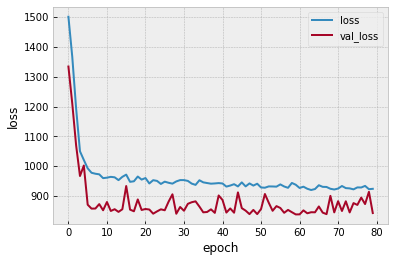

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 20)
model_checkpoint = ModelCheckpoint('models/GRU_model.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)

hist_model = model.fit(
    X_train, y_train,
    epochs = 100,
    batch_size = 256,
    verbose = 2, 
    validation_data = (X_valid, y_valid),
    callbacks = [early_stopping, model_checkpoint]
)

plt.plot(hist_model.history['loss'], label = 'loss')
plt.plot(hist_model.history['val_loss'], label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
model = load_model('models/GRU_model.h5')

In [ ]:
y_pred = model.predict(X_valid)
y_true = y_valid.values

In [ ]:
np.mean(np.sqrt(np.mean(np.square(y_true - y_pred), axis = 0)))

26.595546342115313

In [ ]:
pred = model.predict(X_test)
sample_submission = pd.DataFrame(data = pred, columns = sample_submission.columns, index = sample_submission.index)
sample_submission.to_csv('submissions/submission_GRU.csv')